<a href="https://colab.research.google.com/github/Yaron-Grushka/music-genre-classification/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uploading the DATA to Colab

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"edenbartov","key":"1392e6d7d7555c4bd60357718a1337d9"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                       title                                         size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020             16KB  2021-01-30 14:20:45           4329  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                    9MB  2021-03-01 08:19:18           1976  
yorkehead/stock-market-subreddits                         Stock Market Subreddits                        1MB  2021-01-29 13:53:50            390  
aagghh/crypto-telegram-groups                             Crypto telegram groups                       297MB  2021-02-02 09:58:25            240  
timoboz/superbowl-history-1967-2020                       Superbowl History 1967 - 2020                  2KB  2020-02-

In [4]:
! kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 98% 1.19G/1.21G [00:13<00:00, 96.8MB/s]
100% 1.21G/1.21G [00:13<00:00, 93.2MB/s]


In [5]:
! mkdir dataset-music-genre 
! unzip gtzan-dataset-music-genre-classification.zip -d dataset-music-genre



Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: dataset-music-genre/Data/features_30_sec.csv  
  inflating: dataset-music-genre/Data/features_3_sec.csv  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00000.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00001.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00002.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00003.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00004.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00005.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00006.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00007.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00008.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00009.wav  
  inflating: dataset-music-genre/Data/genres_o

# Code

In [6]:

from __future__ import print_function, division
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import torch.nn.functional as F
import requests
import torchvision.models as vision_models


In [7]:
data_dir='dataset-music-genre/Data/images_original/'
BATCH_SIZE = 16

transform = transforms.Compose([transforms.Resize(244),
                                transforms.CenterCrop(244),                              
                                transforms.ToTensor()])

dataset = datasets.ImageFolder(data_dir, transform=transform)


trainset ,testset = torch.utils.data.random_split(dataset,[800,199], generator=torch.Generator().manual_seed(42))


trainloader =  torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def test_loss(net, criterion, test_loss_history):
  running_loss = 0.0
  with torch.no_grad():
    for data in testloader:
      inputs, labels = data
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU
      output = net(inputs)
      loss = criterion(output, labels)
      running_loss += loss.item()
    test_loss_history.append(running_loss/len(testloader))


def train_network(net, EPOCHS):
  criterion = nn.CrossEntropyLoss()
  learning_rate=0.001
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
  train_loss_history = []
  test_loss_history = []
  
  for epoch in range(EPOCHS):
      correct = 0
      loss = 0
      net.train()
      for batch_idx, (X_batch, y_batch) in enumerate(trainloader):
          X_batch = X_batch.cuda()
          y_batch = y_batch.cuda()
          optimizer.zero_grad()
          output = net(X_batch)
          loss = criterion(output, y_batch)

          loss.backward()
          optimizer.step()

          # Total correct predictions
          predicted = torch.max(output.data, 1)[1] 
          correct += (predicted == y_batch).sum()
          if batch_idx % 50 == 0:
              print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(epoch, batch_idx*len(X_batch), len(trainloader.dataset), 100.*batch_idx / len(trainloader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
      
      train_loss_history.append(loss)
      net.eval()
      test_loss(net, criterion, test_loss_history)

  return train_loss_history, test_loss_history


def plot_loss(train_loss_history, test_loss_history, acc, description):
  # Plot the loss over the epochs
  plt.plot(np.arange(len(train_loss_history)) + 1, train_loss_history, color='b', label='Train') 
  plt.plot(np.arange(len(test_loss_history)) + 1, test_loss_history, color = 'r', label='Test')

  plt.title(f'Changes to model: {description}\nTest accuracy: {str(round(acc, 3))}%')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  path_to_save = '/content/drive/My Drive/net images/' + description
  plt.savefig(path_to_save)
  plt.show()

def calc_accuracy(net):
  print(net.eval())
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.cuda(), labels.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  acc = 100 * correct / total
  print('Accuracy of the network on the test images: %d %%' % (acc))
  return acc

In [17]:
class CNN0(nn.Module):
    def __init__(self,original_model=None):
        super(CNN0, self).__init__()
        
        # Convolutional layers:
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        
        # Linear layers:
        self.fc1 = nn.Linear(476288, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
      # Convolutional layers:
      x = self.conv1(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv2(x)
      x = F.max_pool2d(F.relu(x), 2)

      x = x.view(x.size(0), -1)
      # Linear layers:
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      
      return x

##############################
Epochs: 10
##############################
Epoch : 0 [0/800 (0%)]	Loss: 2.306115	 Accuracy:6.250%
Epoch : 1 [0/800 (0%)]	Loss: 2.299942	 Accuracy:12.500%
Epoch : 2 [0/800 (0%)]	Loss: 2.296304	 Accuracy:25.000%
Epoch : 3 [0/800 (0%)]	Loss: 2.305797	 Accuracy:12.500%
Epoch : 4 [0/800 (0%)]	Loss: 2.292761	 Accuracy:31.250%
Epoch : 5 [0/800 (0%)]	Loss: 2.306908	 Accuracy:12.500%
Epoch : 6 [0/800 (0%)]	Loss: 2.303994	 Accuracy:12.500%
Epoch : 7 [0/800 (0%)]	Loss: 2.301647	 Accuracy:6.250%
Epoch : 8 [0/800 (0%)]	Loss: 2.309071	 Accuracy:12.500%
Epoch : 9 [0/800 (0%)]	Loss: 2.313864	 Accuracy:6.250%
CNN0(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=476288, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Accuracy of the network on the test images: 8 %


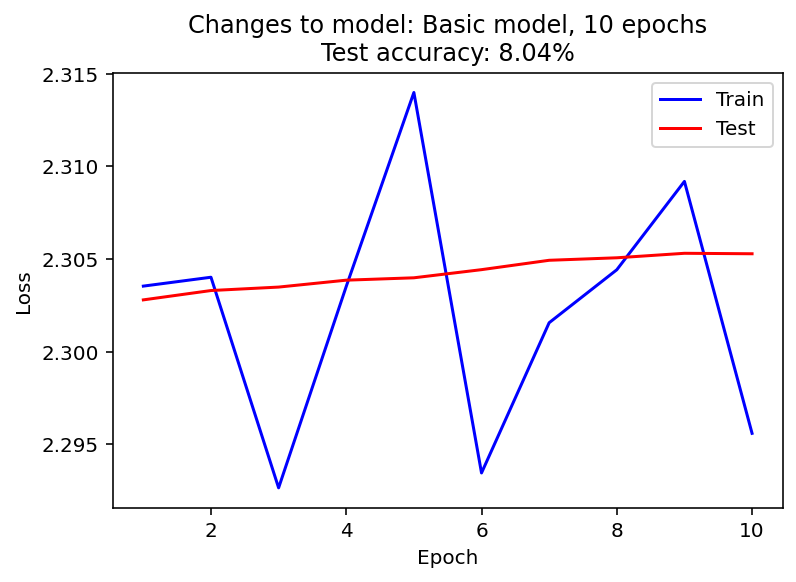

##############################
Epochs: 20
##############################
Epoch : 0 [0/800 (0%)]	Loss: 2.298952	 Accuracy:0.000%
Epoch : 1 [0/800 (0%)]	Loss: 2.221698	 Accuracy:31.250%
Epoch : 2 [0/800 (0%)]	Loss: 1.793335	 Accuracy:37.500%
Epoch : 3 [0/800 (0%)]	Loss: 1.703692	 Accuracy:37.500%
Epoch : 4 [0/800 (0%)]	Loss: 1.789306	 Accuracy:31.250%
Epoch : 5 [0/800 (0%)]	Loss: 1.520690	 Accuracy:56.250%
Epoch : 6 [0/800 (0%)]	Loss: 0.798168	 Accuracy:81.250%
Epoch : 7 [0/800 (0%)]	Loss: 0.854167	 Accuracy:75.000%
Epoch : 8 [0/800 (0%)]	Loss: 0.389432	 Accuracy:87.500%
Epoch : 9 [0/800 (0%)]	Loss: 0.283252	 Accuracy:87.500%
Epoch : 10 [0/800 (0%)]	Loss: 0.042639	 Accuracy:100.000%
Epoch : 11 [0/800 (0%)]	Loss: 0.111459	 Accuracy:100.000%
Epoch : 12 [0/800 (0%)]	Loss: 0.030230	 Accuracy:100.000%
Epoch : 13 [0/800 (0%)]	Loss: 0.007698	 Accuracy:100.000%
Epoch : 14 [0/800 (0%)]	Loss: 0.007078	 Accuracy:100.000%
Epoch : 15 [0/800 (0%)]	Loss: 0.011317	 Accuracy:100.000%
Epoch : 16 [0/800 (0

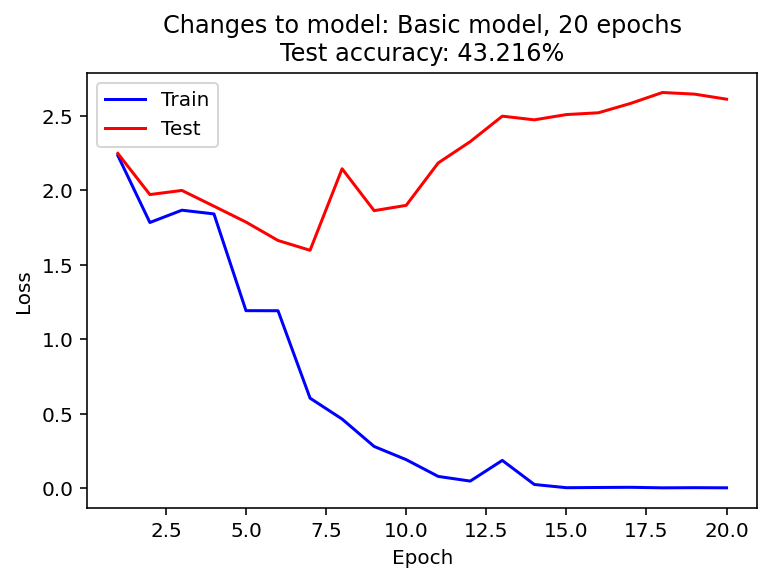

In [18]:
for i in [10, 20]:
  print('#' * 30)
  print(f'Epochs: {i}')
  print('#' * 30)
  net = CNN0().cuda()
  train_loss_history, test_loss_history = train_network(net, i)
  acc = calc_accuracy(net)
  plot_loss(train_loss_history, test_loss_history, acc, f'Basic model, {i} epochs')

In [19]:
class CNN1(nn.Module):
    def __init__(self,original_model=None):
        super(CNN1, self).__init__()
        
        # Convolutional layers:
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        
        # Linear layers:
        self.fc1 = nn.Linear(4608, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
      # Convolutional layers:
      x = self.conv1(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv2(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv3(x)
      x = F.max_pool2d(F.relu(x), 4)
      x = self.conv4(x)
      x = F.max_pool2d(F.relu(x), 4)

      x = x.view(x.size(0), -1)

      # Linear layers:
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      
      return x
    

Epoch : 0 [0/800 (0%)]	Loss: 2.296138	 Accuracy:6.250%
Epoch : 1 [0/800 (0%)]	Loss: 2.297443	 Accuracy:18.750%
Epoch : 2 [0/800 (0%)]	Loss: 2.017188	 Accuracy:25.000%
Epoch : 3 [0/800 (0%)]	Loss: 2.178937	 Accuracy:18.750%
Epoch : 4 [0/800 (0%)]	Loss: 2.206879	 Accuracy:12.500%
Epoch : 5 [0/800 (0%)]	Loss: 1.849957	 Accuracy:43.750%
Epoch : 6 [0/800 (0%)]	Loss: 2.084609	 Accuracy:18.750%
Epoch : 7 [0/800 (0%)]	Loss: 2.439492	 Accuracy:0.000%
Epoch : 8 [0/800 (0%)]	Loss: 1.999295	 Accuracy:31.250%
Epoch : 9 [0/800 (0%)]	Loss: 1.969687	 Accuracy:18.750%
Epoch : 10 [0/800 (0%)]	Loss: 1.786563	 Accuracy:43.750%
Epoch : 11 [0/800 (0%)]	Loss: 2.038382	 Accuracy:25.000%
Epoch : 12 [0/800 (0%)]	Loss: 1.938678	 Accuracy:18.750%
Epoch : 13 [0/800 (0%)]	Loss: 1.791888	 Accuracy:25.000%
Epoch : 14 [0/800 (0%)]	Loss: 1.889276	 Accuracy:25.000%
Epoch : 15 [0/800 (0%)]	Loss: 1.825686	 Accuracy:25.000%
Epoch : 16 [0/800 (0%)]	Loss: 1.949046	 Accuracy:25.000%
Epoch : 17 [0/800 (0%)]	Loss: 1.226666	 Acc

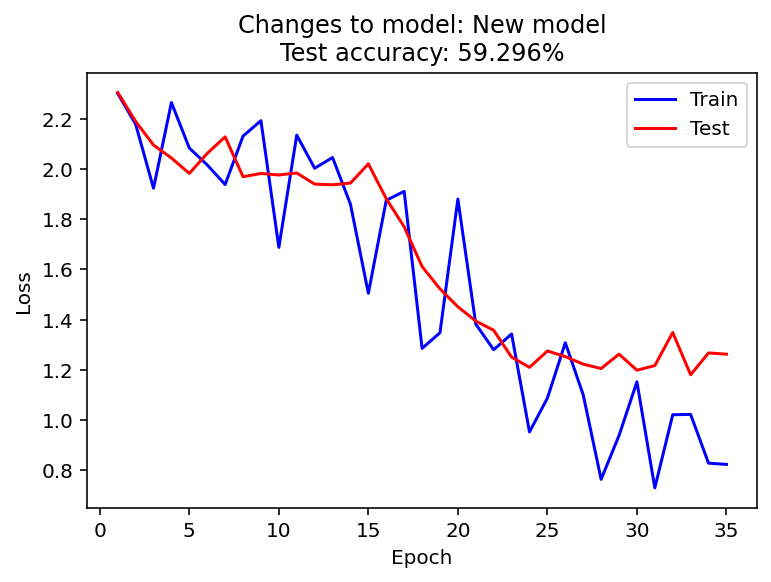

In [20]:
net = CNN1().cuda()
train_loss_history, test_loss_history = train_network(net, 35)
acc = calc_accuracy(net)
plot_loss(train_loss_history, test_loss_history, acc, 'New model')

In [21]:
class CNN2(nn.Module):
    def __init__(self,original_model=None):
        super(CNN2, self).__init__()
        
        # Convolutional layers:
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
        
        # Linear layers:
        self.fc1 = nn.Linear(4608, 1024)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1024, 256)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 10)
        torch.nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
      # Convolutional layers:
      x = self.conv1(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv2(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv3(x)
      x = F.max_pool2d(F.relu(x), 4)
      x = self.conv4(x)
      x = F.max_pool2d(F.relu(x), 4)

      x = x.view(x.size(0), -1)

      # Linear layers:
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      
      return x

##############################
Epochs: 10
##############################
Epoch : 0 [0/800 (0%)]	Loss: 2.383056	 Accuracy:6.250%
Epoch : 1 [0/800 (0%)]	Loss: 2.166580	 Accuracy:25.000%
Epoch : 2 [0/800 (0%)]	Loss: 2.195906	 Accuracy:6.250%
Epoch : 3 [0/800 (0%)]	Loss: 1.838719	 Accuracy:50.000%
Epoch : 4 [0/800 (0%)]	Loss: 1.723358	 Accuracy:31.250%
Epoch : 5 [0/800 (0%)]	Loss: 1.512602	 Accuracy:50.000%
Epoch : 6 [0/800 (0%)]	Loss: 1.823112	 Accuracy:37.500%
Epoch : 7 [0/800 (0%)]	Loss: 1.526727	 Accuracy:50.000%
Epoch : 8 [0/800 (0%)]	Loss: 1.376298	 Accuracy:43.750%
Epoch : 9 [0/800 (0%)]	Loss: 0.681298	 Accuracy:75.000%
CNN2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=1024

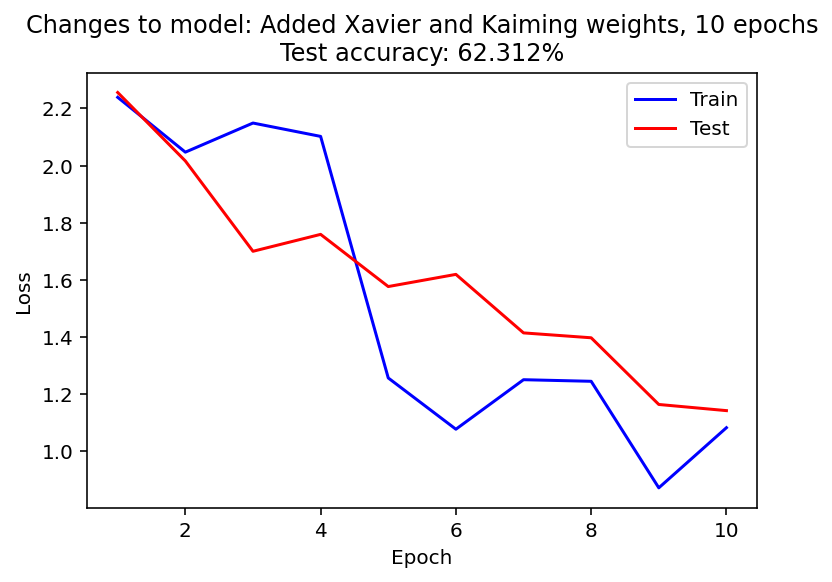

##############################
Epochs: 15
##############################
Epoch : 0 [0/800 (0%)]	Loss: 2.992514	 Accuracy:12.500%
Epoch : 1 [0/800 (0%)]	Loss: 2.247790	 Accuracy:6.250%
Epoch : 2 [0/800 (0%)]	Loss: 2.057013	 Accuracy:18.750%
Epoch : 3 [0/800 (0%)]	Loss: 1.987670	 Accuracy:12.500%
Epoch : 4 [0/800 (0%)]	Loss: 2.018388	 Accuracy:25.000%
Epoch : 5 [0/800 (0%)]	Loss: 1.786592	 Accuracy:18.750%
Epoch : 6 [0/800 (0%)]	Loss: 2.002713	 Accuracy:25.000%
Epoch : 7 [0/800 (0%)]	Loss: 1.315869	 Accuracy:56.250%
Epoch : 8 [0/800 (0%)]	Loss: 1.123120	 Accuracy:62.500%
Epoch : 9 [0/800 (0%)]	Loss: 1.156801	 Accuracy:56.250%
Epoch : 10 [0/800 (0%)]	Loss: 0.695334	 Accuracy:75.000%
Epoch : 11 [0/800 (0%)]	Loss: 0.930515	 Accuracy:68.750%
Epoch : 12 [0/800 (0%)]	Loss: 0.648718	 Accuracy:68.750%
Epoch : 13 [0/800 (0%)]	Loss: 0.499384	 Accuracy:87.500%
Epoch : 14 [0/800 (0%)]	Loss: 0.350609	 Accuracy:87.500%
CNN2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

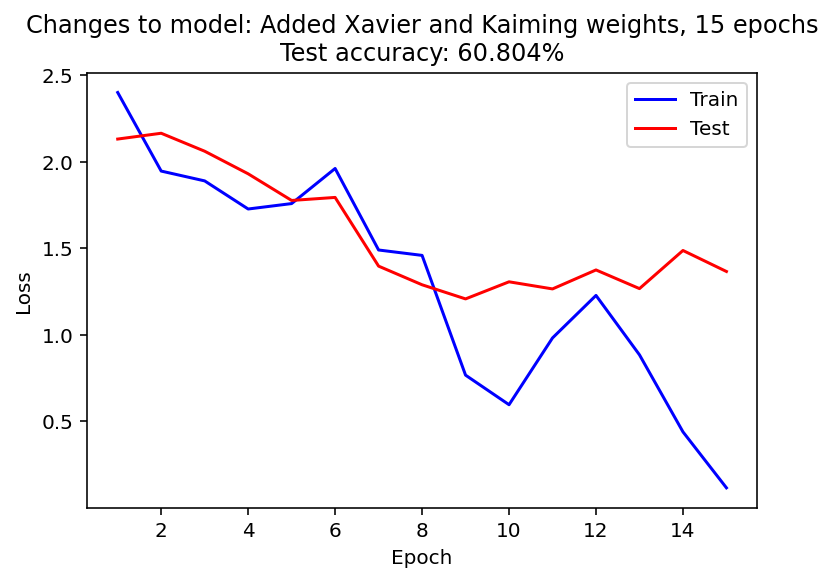

##############################
Epochs: 20
##############################
Epoch : 0 [0/800 (0%)]	Loss: 2.316457	 Accuracy:12.500%
Epoch : 1 [0/800 (0%)]	Loss: 2.334035	 Accuracy:18.750%
Epoch : 2 [0/800 (0%)]	Loss: 2.593776	 Accuracy:12.500%
Epoch : 3 [0/800 (0%)]	Loss: 1.695298	 Accuracy:25.000%
Epoch : 4 [0/800 (0%)]	Loss: 1.884137	 Accuracy:25.000%
Epoch : 5 [0/800 (0%)]	Loss: 1.518721	 Accuracy:43.750%
Epoch : 6 [0/800 (0%)]	Loss: 1.112391	 Accuracy:62.500%
Epoch : 7 [0/800 (0%)]	Loss: 1.456639	 Accuracy:50.000%
Epoch : 8 [0/800 (0%)]	Loss: 1.629601	 Accuracy:50.000%
Epoch : 9 [0/800 (0%)]	Loss: 1.081005	 Accuracy:50.000%
Epoch : 10 [0/800 (0%)]	Loss: 0.609025	 Accuracy:81.250%
Epoch : 11 [0/800 (0%)]	Loss: 0.882592	 Accuracy:75.000%
Epoch : 12 [0/800 (0%)]	Loss: 0.470992	 Accuracy:81.250%
Epoch : 13 [0/800 (0%)]	Loss: 0.624501	 Accuracy:81.250%
Epoch : 14 [0/800 (0%)]	Loss: 0.515628	 Accuracy:87.500%
Epoch : 15 [0/800 (0%)]	Loss: 0.083381	 Accuracy:100.000%
Epoch : 16 [0/800 (0%)]	

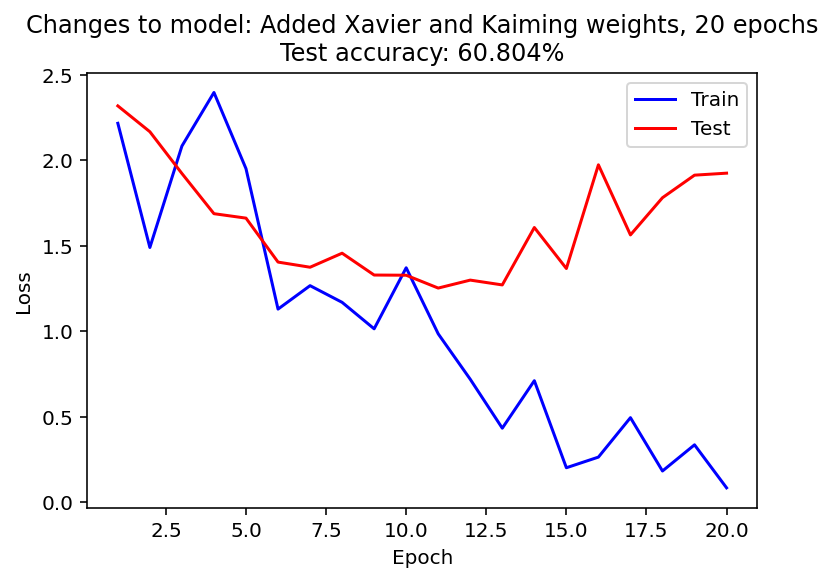

In [22]:
for i in [10, 15, 20]:
  print('#' * 30)
  print(f'Epochs: {i}')
  print('#' * 30)
  net = CNN2().cuda()
  train_loss_history, test_loss_history = train_network(net, i)
  acc = calc_accuracy(net)
  plot_loss(train_loss_history, test_loss_history, acc, f'Added Xavier and Kaiming weights, {i} epochs')

In [23]:
class CNN3(nn.Module):
    def __init__(self,original_model=None):
        super(CNN3, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
        
        # Linear layers:
        self.fc1 = nn.Linear(4608, 1024)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1024, 256)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 10)
        torch.nn.init.xavier_normal_(self.fc3.weight)

        self.dropout = nn.Dropout()

    def forward(self, x):
      # Convolutional layers:
      x = self.conv1(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv2(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv3(x)
      x = F.max_pool2d(F.relu(x), 4)
      x = self.conv4(x)
      x = F.max_pool2d(F.relu(x), 4)

      x = x.view(x.size(0), -1)

      # Linear layers:
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)
      
      return x

Epoch : 0 [0/800 (0%)]	Loss: 3.245607	 Accuracy:6.250%
Epoch : 1 [0/800 (0%)]	Loss: 2.344175	 Accuracy:0.000%
Epoch : 2 [0/800 (0%)]	Loss: 2.081447	 Accuracy:18.750%
Epoch : 3 [0/800 (0%)]	Loss: 2.127391	 Accuracy:12.500%
Epoch : 4 [0/800 (0%)]	Loss: 1.962313	 Accuracy:18.750%
Epoch : 5 [0/800 (0%)]	Loss: 1.759588	 Accuracy:43.750%
Epoch : 6 [0/800 (0%)]	Loss: 1.752011	 Accuracy:31.250%
Epoch : 7 [0/800 (0%)]	Loss: 1.495517	 Accuracy:31.250%
Epoch : 8 [0/800 (0%)]	Loss: 1.431055	 Accuracy:43.750%
Epoch : 9 [0/800 (0%)]	Loss: 1.817662	 Accuracy:25.000%
Epoch : 10 [0/800 (0%)]	Loss: 1.478514	 Accuracy:43.750%
Epoch : 11 [0/800 (0%)]	Loss: 1.306434	 Accuracy:50.000%
Epoch : 12 [0/800 (0%)]	Loss: 1.246231	 Accuracy:43.750%
Epoch : 13 [0/800 (0%)]	Loss: 0.886445	 Accuracy:62.500%
Epoch : 14 [0/800 (0%)]	Loss: 1.032951	 Accuracy:68.750%
Epoch : 15 [0/800 (0%)]	Loss: 0.742842	 Accuracy:75.000%
Epoch : 16 [0/800 (0%)]	Loss: 0.580851	 Accuracy:81.250%
Epoch : 17 [0/800 (0%)]	Loss: 0.255100	 Acc

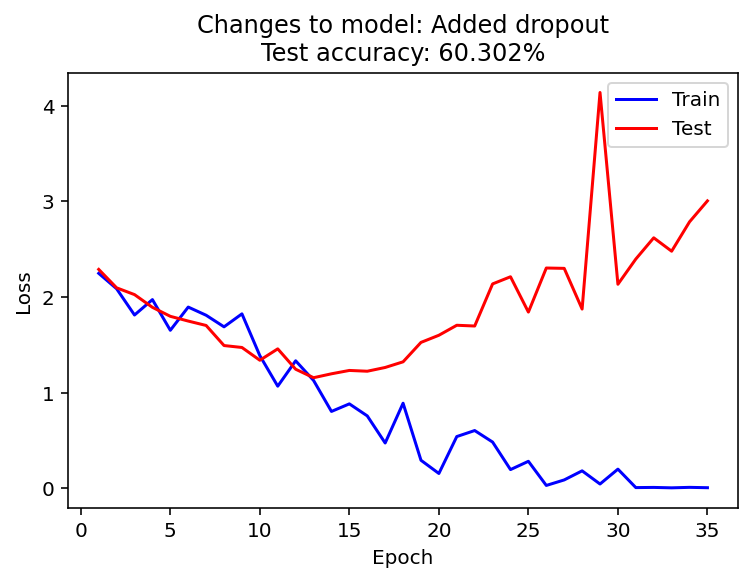

In [24]:
net = CNN3().cuda()
train_loss_history, test_loss_history = train_network(net, 35)
acc = calc_accuracy(net)
plot_loss(train_loss_history, test_loss_history, acc, 'Added dropout')

In [25]:
class CNN4(nn.Module):
    def __init__(self,original_model=None):
        super(CNN4, self).__init__()
        
        # Convolutional layers:
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
        
        # Linear layers:
        self.fc1 = nn.Linear(4608, 1024)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1024, 256)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 10)
        torch.nn.init.xavier_normal_(self.fc3.weight)

        # Normalizations:
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()

    def forward(self, x):
      # Convolutional layers:
      x = self.batchnorm1(self.conv1(x))
      x = F.max_pool2d(F.relu(x), 2)
      x = self.batchnorm2(self.conv2(x))
      x = F.max_pool2d(F.relu(x), 2)
      x = self.batchnorm3(self.conv3(x))
      x = F.max_pool2d(F.relu(x), 4)
      x = self.batchnorm4(self.conv4(x))
      x = F.max_pool2d(F.relu(x), 4)

      x = x.view(x.size(0), -1)

      # Linear layers:
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)
      
      return x

Epoch : 0 [0/800 (0%)]	Loss: 4.622965	 Accuracy:12.500%
Epoch : 1 [0/800 (0%)]	Loss: 2.511646	 Accuracy:6.250%
Epoch : 2 [0/800 (0%)]	Loss: 2.141654	 Accuracy:12.500%
Epoch : 3 [0/800 (0%)]	Loss: 1.859982	 Accuracy:37.500%
Epoch : 4 [0/800 (0%)]	Loss: 2.309183	 Accuracy:31.250%
Epoch : 5 [0/800 (0%)]	Loss: 1.487288	 Accuracy:37.500%
Epoch : 6 [0/800 (0%)]	Loss: 1.331971	 Accuracy:43.750%
Epoch : 7 [0/800 (0%)]	Loss: 1.200763	 Accuracy:62.500%
Epoch : 8 [0/800 (0%)]	Loss: 1.302283	 Accuracy:43.750%
Epoch : 9 [0/800 (0%)]	Loss: 1.264412	 Accuracy:56.250%
Epoch : 10 [0/800 (0%)]	Loss: 1.662191	 Accuracy:31.250%
Epoch : 11 [0/800 (0%)]	Loss: 1.366458	 Accuracy:56.250%
Epoch : 12 [0/800 (0%)]	Loss: 1.429405	 Accuracy:31.250%
Epoch : 13 [0/800 (0%)]	Loss: 1.569471	 Accuracy:56.250%
Epoch : 14 [0/800 (0%)]	Loss: 1.775284	 Accuracy:37.500%
Epoch : 15 [0/800 (0%)]	Loss: 1.165709	 Accuracy:56.250%
Epoch : 16 [0/800 (0%)]	Loss: 1.400750	 Accuracy:43.750%
Epoch : 17 [0/800 (0%)]	Loss: 1.304340	 Ac

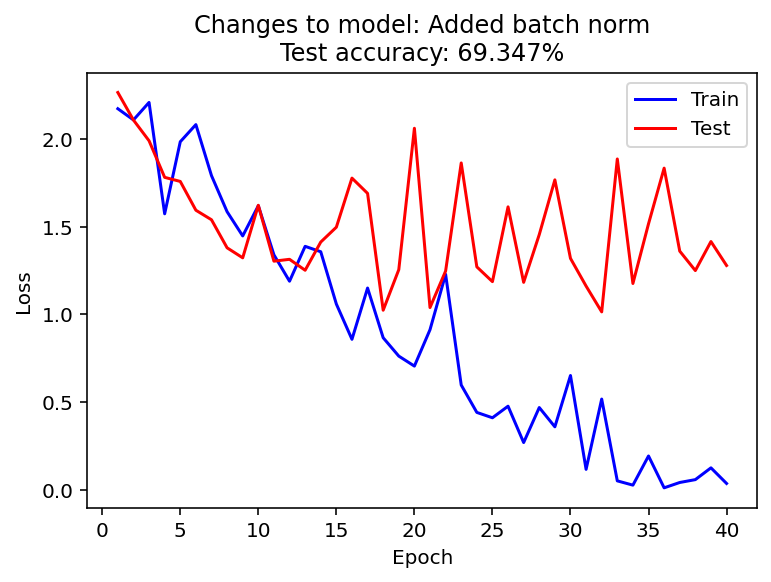

In [26]:
net = CNN4().cuda()
train_loss_history, test_loss_history = train_network(net, 40)
acc = calc_accuracy(net)
plot_loss(train_loss_history, test_loss_history, acc, 'Added batch norm')

In [9]:
class CNN_FINAL(nn.Module):
    def __init__(self,original_model=None):
        super(CNN_FINAL, self).__init__()
        
        # Convolutional layers:
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
        
        # Linear layers:
        self.fc1 = nn.Linear(4608, 1024)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1024, 256)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 10)
        torch.nn.init.xavier_normal_(self.fc3.weight)

        # Normalizations:
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()

    def forward(self, x):
      # Convolutional layers:
      x = self.batchnorm1(self.conv1(x))
      x = F.max_pool2d(F.relu(x), 2)
      x = self.batchnorm2(self.conv2(x))
      x = F.max_pool2d(F.relu(x), 2)
      x = self.batchnorm3(self.conv3(x))
      x = F.max_pool2d(F.relu(x), 4)
      x = self.batchnorm4(self.conv4(x))
      x = F.max_pool2d(F.relu(x), 4)

      x = x.view(x.size(0), -1)

      # Linear layers:
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)
      
      return F.log_softmax(x, dim=1)

##############################
Epochs: 30
##############################
Epoch : 0 [0/800 (0%)]	Loss: 4.972233	 Accuracy:0.000%
Epoch : 1 [0/800 (0%)]	Loss: 2.266367	 Accuracy:12.500%
Epoch : 2 [0/800 (0%)]	Loss: 2.053471	 Accuracy:31.250%
Epoch : 3 [0/800 (0%)]	Loss: 2.093264	 Accuracy:25.000%
Epoch : 4 [0/800 (0%)]	Loss: 2.067228	 Accuracy:18.750%
Epoch : 5 [0/800 (0%)]	Loss: 2.352035	 Accuracy:12.500%
Epoch : 6 [0/800 (0%)]	Loss: 1.445172	 Accuracy:62.500%
Epoch : 7 [0/800 (0%)]	Loss: 1.591628	 Accuracy:56.250%
Epoch : 8 [0/800 (0%)]	Loss: 1.236816	 Accuracy:62.500%
Epoch : 9 [0/800 (0%)]	Loss: 1.211736	 Accuracy:75.000%
Epoch : 10 [0/800 (0%)]	Loss: 1.314342	 Accuracy:50.000%
Epoch : 11 [0/800 (0%)]	Loss: 1.801321	 Accuracy:37.500%
Epoch : 12 [0/800 (0%)]	Loss: 1.359459	 Accuracy:37.500%
Epoch : 13 [0/800 (0%)]	Loss: 0.529985	 Accuracy:93.750%
Epoch : 14 [0/800 (0%)]	Loss: 0.756232	 Accuracy:68.750%
Epoch : 15 [0/800 (0%)]	Loss: 1.318723	 Accuracy:43.750%
Epoch : 16 [0/800 (0%)]	Lo

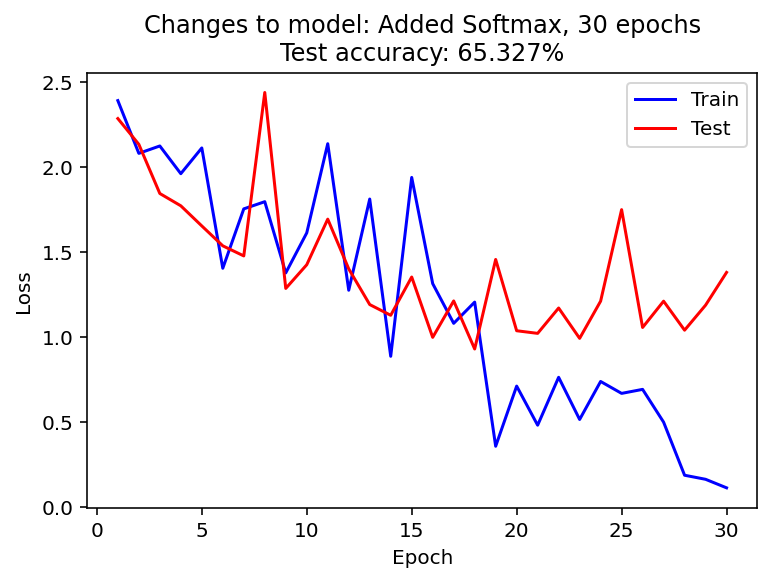

##############################
Epochs: 40
##############################
Epoch : 0 [0/800 (0%)]	Loss: 5.312157	 Accuracy:12.500%
Epoch : 1 [0/800 (0%)]	Loss: 2.163823	 Accuracy:12.500%
Epoch : 2 [0/800 (0%)]	Loss: 2.028114	 Accuracy:18.750%
Epoch : 3 [0/800 (0%)]	Loss: 1.885223	 Accuracy:37.500%
Epoch : 4 [0/800 (0%)]	Loss: 1.937684	 Accuracy:25.000%
Epoch : 5 [0/800 (0%)]	Loss: 2.010451	 Accuracy:18.750%
Epoch : 6 [0/800 (0%)]	Loss: 1.676560	 Accuracy:43.750%
Epoch : 7 [0/800 (0%)]	Loss: 1.428679	 Accuracy:31.250%
Epoch : 8 [0/800 (0%)]	Loss: 1.600542	 Accuracy:62.500%
Epoch : 9 [0/800 (0%)]	Loss: 1.331805	 Accuracy:50.000%
Epoch : 10 [0/800 (0%)]	Loss: 1.663122	 Accuracy:37.500%
Epoch : 11 [0/800 (0%)]	Loss: 1.532587	 Accuracy:50.000%
Epoch : 12 [0/800 (0%)]	Loss: 1.065909	 Accuracy:68.750%
Epoch : 13 [0/800 (0%)]	Loss: 1.603948	 Accuracy:37.500%
Epoch : 14 [0/800 (0%)]	Loss: 1.101747	 Accuracy:56.250%
Epoch : 15 [0/800 (0%)]	Loss: 1.546084	 Accuracy:43.750%
Epoch : 16 [0/800 (0%)]	L

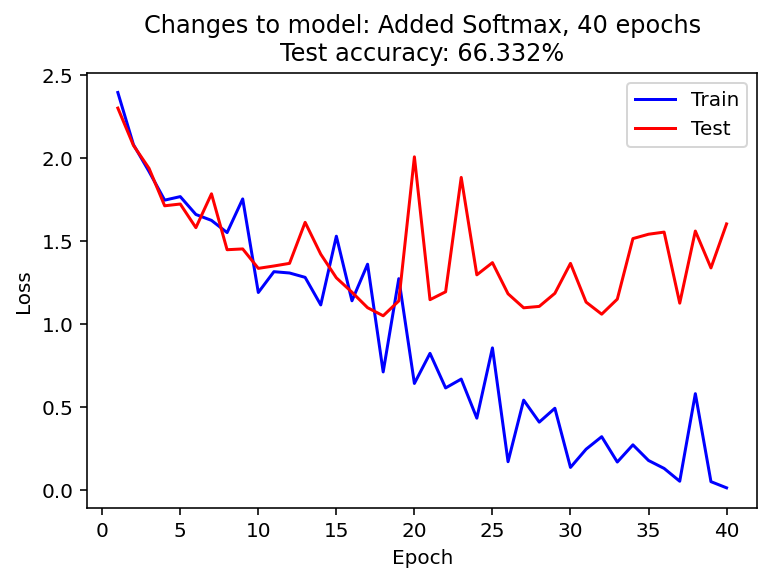

##############################
Epochs: 50
##############################
Epoch : 0 [0/800 (0%)]	Loss: 3.514812	 Accuracy:12.500%
Epoch : 1 [0/800 (0%)]	Loss: 2.188091	 Accuracy:12.500%
Epoch : 2 [0/800 (0%)]	Loss: 2.035781	 Accuracy:18.750%
Epoch : 3 [0/800 (0%)]	Loss: 1.694379	 Accuracy:43.750%
Epoch : 4 [0/800 (0%)]	Loss: 1.949679	 Accuracy:31.250%
Epoch : 5 [0/800 (0%)]	Loss: 1.781402	 Accuracy:18.750%
Epoch : 6 [0/800 (0%)]	Loss: 1.889725	 Accuracy:18.750%
Epoch : 7 [0/800 (0%)]	Loss: 1.230036	 Accuracy:62.500%
Epoch : 8 [0/800 (0%)]	Loss: 1.746886	 Accuracy:31.250%
Epoch : 9 [0/800 (0%)]	Loss: 1.501933	 Accuracy:37.500%
Epoch : 10 [0/800 (0%)]	Loss: 1.768865	 Accuracy:43.750%
Epoch : 11 [0/800 (0%)]	Loss: 1.171593	 Accuracy:43.750%
Epoch : 12 [0/800 (0%)]	Loss: 1.309729	 Accuracy:56.250%
Epoch : 13 [0/800 (0%)]	Loss: 1.144036	 Accuracy:75.000%
Epoch : 14 [0/800 (0%)]	Loss: 0.820660	 Accuracy:68.750%
Epoch : 15 [0/800 (0%)]	Loss: 1.117326	 Accuracy:62.500%
Epoch : 16 [0/800 (0%)]	L

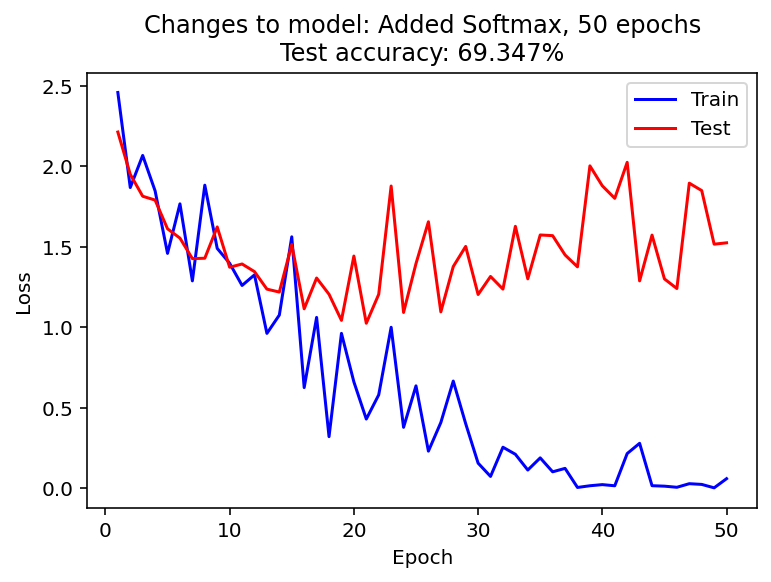

##############################
Epochs: 60
##############################
Epoch : 0 [0/800 (0%)]	Loss: 5.229605	 Accuracy:25.000%
Epoch : 1 [0/800 (0%)]	Loss: 2.249214	 Accuracy:18.750%
Epoch : 2 [0/800 (0%)]	Loss: 2.399134	 Accuracy:6.250%
Epoch : 3 [0/800 (0%)]	Loss: 2.004576	 Accuracy:37.500%
Epoch : 4 [0/800 (0%)]	Loss: 2.018512	 Accuracy:31.250%
Epoch : 5 [0/800 (0%)]	Loss: 1.973571	 Accuracy:12.500%
Epoch : 6 [0/800 (0%)]	Loss: 1.751732	 Accuracy:37.500%
Epoch : 7 [0/800 (0%)]	Loss: 1.792293	 Accuracy:31.250%
Epoch : 8 [0/800 (0%)]	Loss: 1.432810	 Accuracy:43.750%
Epoch : 9 [0/800 (0%)]	Loss: 1.043594	 Accuracy:62.500%
Epoch : 10 [0/800 (0%)]	Loss: 1.886452	 Accuracy:43.750%
Epoch : 11 [0/800 (0%)]	Loss: 1.480536	 Accuracy:43.750%
Epoch : 12 [0/800 (0%)]	Loss: 1.509327	 Accuracy:50.000%
Epoch : 13 [0/800 (0%)]	Loss: 1.503584	 Accuracy:50.000%
Epoch : 14 [0/800 (0%)]	Loss: 1.157801	 Accuracy:56.250%
Epoch : 15 [0/800 (0%)]	Loss: 0.936507	 Accuracy:68.750%
Epoch : 16 [0/800 (0%)]	Lo

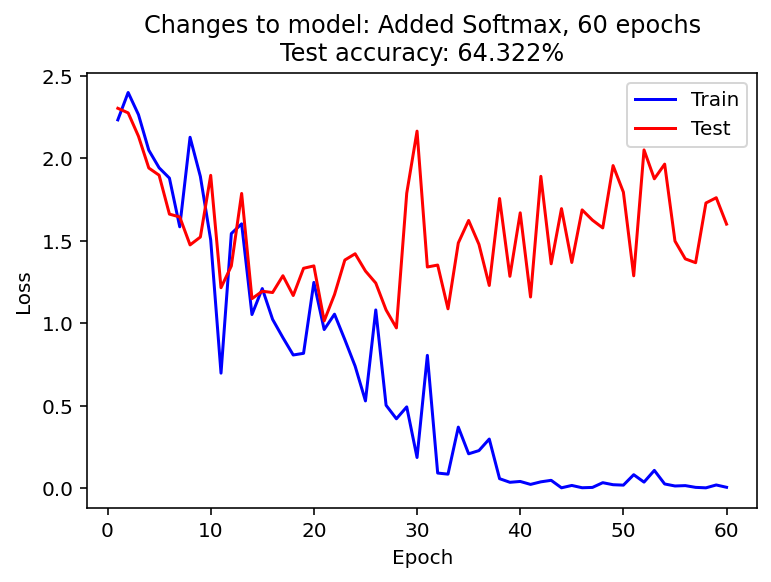

##############################
Epochs: 70
##############################
Epoch : 0 [0/800 (0%)]	Loss: 3.309382	 Accuracy:18.750%
Epoch : 1 [0/800 (0%)]	Loss: 2.317654	 Accuracy:18.750%
Epoch : 2 [0/800 (0%)]	Loss: 2.284100	 Accuracy:18.750%
Epoch : 3 [0/800 (0%)]	Loss: 2.090755	 Accuracy:25.000%
Epoch : 4 [0/800 (0%)]	Loss: 2.180618	 Accuracy:6.250%
Epoch : 5 [0/800 (0%)]	Loss: 1.555292	 Accuracy:37.500%
Epoch : 6 [0/800 (0%)]	Loss: 1.795426	 Accuracy:12.500%
Epoch : 7 [0/800 (0%)]	Loss: 1.667773	 Accuracy:37.500%
Epoch : 8 [0/800 (0%)]	Loss: 1.787948	 Accuracy:31.250%
Epoch : 9 [0/800 (0%)]	Loss: 1.910947	 Accuracy:18.750%
Epoch : 10 [0/800 (0%)]	Loss: 1.705356	 Accuracy:37.500%
Epoch : 11 [0/800 (0%)]	Loss: 1.519872	 Accuracy:50.000%
Epoch : 12 [0/800 (0%)]	Loss: 1.322203	 Accuracy:37.500%
Epoch : 13 [0/800 (0%)]	Loss: 2.005543	 Accuracy:43.750%
Epoch : 14 [0/800 (0%)]	Loss: 1.052940	 Accuracy:68.750%
Epoch : 15 [0/800 (0%)]	Loss: 1.569568	 Accuracy:50.000%
Epoch : 16 [0/800 (0%)]	Lo

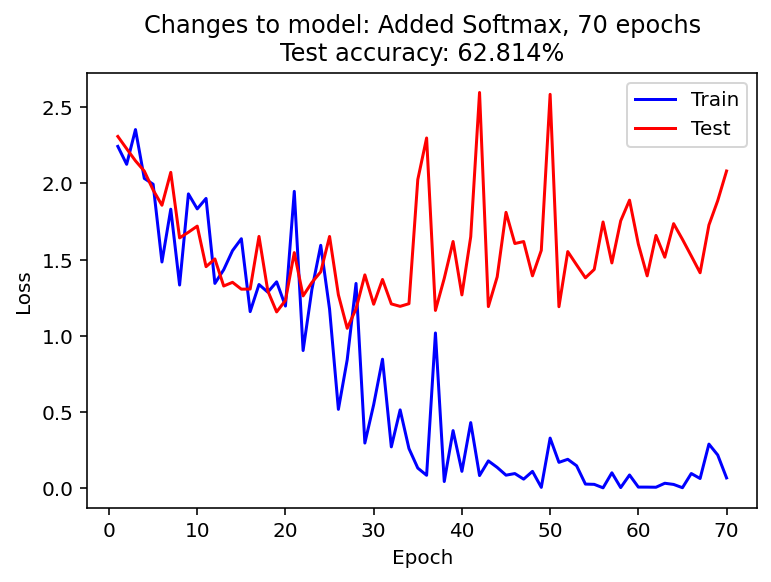

##############################
Epochs: 80
##############################
Epoch : 0 [0/800 (0%)]	Loss: 4.790508	 Accuracy:18.750%
Epoch : 1 [0/800 (0%)]	Loss: 2.402673	 Accuracy:0.000%
Epoch : 2 [0/800 (0%)]	Loss: 2.192208	 Accuracy:12.500%
Epoch : 3 [0/800 (0%)]	Loss: 2.180920	 Accuracy:25.000%
Epoch : 4 [0/800 (0%)]	Loss: 1.725083	 Accuracy:50.000%
Epoch : 5 [0/800 (0%)]	Loss: 1.693800	 Accuracy:37.500%
Epoch : 6 [0/800 (0%)]	Loss: 1.734424	 Accuracy:37.500%
Epoch : 7 [0/800 (0%)]	Loss: 1.479094	 Accuracy:43.750%
Epoch : 8 [0/800 (0%)]	Loss: 1.977627	 Accuracy:31.250%
Epoch : 9 [0/800 (0%)]	Loss: 1.607483	 Accuracy:37.500%
Epoch : 10 [0/800 (0%)]	Loss: 1.289783	 Accuracy:56.250%
Epoch : 11 [0/800 (0%)]	Loss: 1.427529	 Accuracy:62.500%
Epoch : 12 [0/800 (0%)]	Loss: 1.212149	 Accuracy:56.250%
Epoch : 13 [0/800 (0%)]	Loss: 1.043281	 Accuracy:62.500%
Epoch : 14 [0/800 (0%)]	Loss: 1.441551	 Accuracy:31.250%
Epoch : 15 [0/800 (0%)]	Loss: 1.286116	 Accuracy:62.500%
Epoch : 16 [0/800 (0%)]	Lo

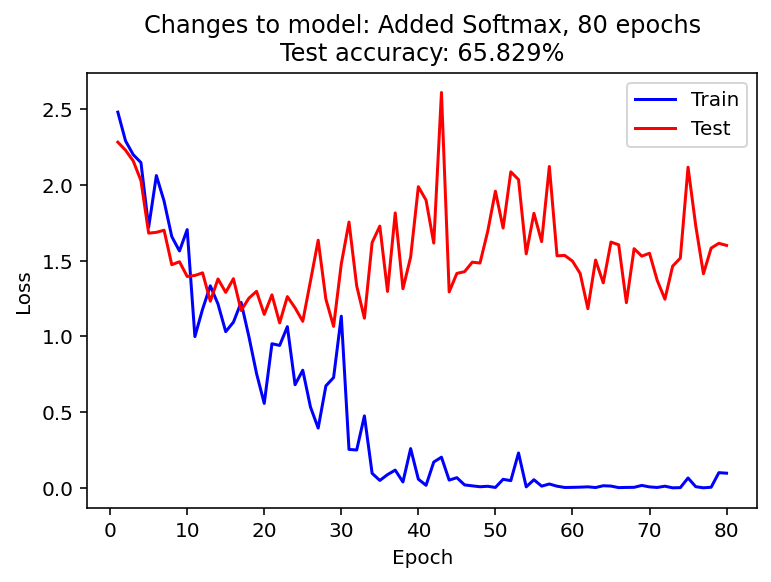

##############################
Epochs: 90
##############################
Epoch : 0 [0/800 (0%)]	Loss: 5.596879	 Accuracy:18.750%
Epoch : 1 [0/800 (0%)]	Loss: 2.172760	 Accuracy:25.000%
Epoch : 2 [0/800 (0%)]	Loss: 1.953987	 Accuracy:25.000%
Epoch : 3 [0/800 (0%)]	Loss: 2.183357	 Accuracy:18.750%
Epoch : 4 [0/800 (0%)]	Loss: 1.614421	 Accuracy:37.500%
Epoch : 5 [0/800 (0%)]	Loss: 2.087073	 Accuracy:25.000%
Epoch : 6 [0/800 (0%)]	Loss: 1.877197	 Accuracy:43.750%
Epoch : 7 [0/800 (0%)]	Loss: 1.960610	 Accuracy:12.500%
Epoch : 8 [0/800 (0%)]	Loss: 1.757458	 Accuracy:37.500%
Epoch : 9 [0/800 (0%)]	Loss: 1.972104	 Accuracy:6.250%
Epoch : 10 [0/800 (0%)]	Loss: 1.543910	 Accuracy:56.250%
Epoch : 11 [0/800 (0%)]	Loss: 1.382426	 Accuracy:50.000%
Epoch : 12 [0/800 (0%)]	Loss: 1.646302	 Accuracy:31.250%
Epoch : 13 [0/800 (0%)]	Loss: 1.107655	 Accuracy:50.000%
Epoch : 14 [0/800 (0%)]	Loss: 1.929602	 Accuracy:25.000%
Epoch : 15 [0/800 (0%)]	Loss: 1.205997	 Accuracy:62.500%
Epoch : 16 [0/800 (0%)]	Lo

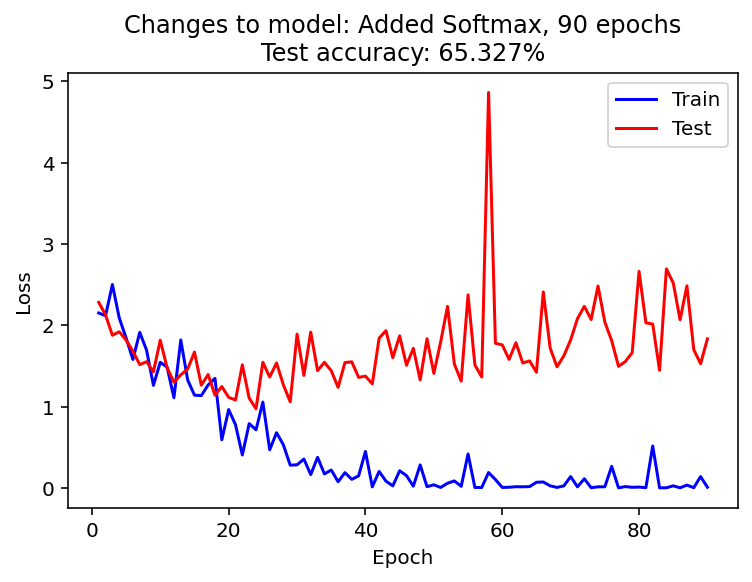

##############################
Epochs: 100
##############################
Epoch : 0 [0/800 (0%)]	Loss: 6.316937	 Accuracy:0.000%
Epoch : 1 [0/800 (0%)]	Loss: 2.326898	 Accuracy:6.250%
Epoch : 2 [0/800 (0%)]	Loss: 1.863904	 Accuracy:50.000%
Epoch : 3 [0/800 (0%)]	Loss: 2.356455	 Accuracy:12.500%
Epoch : 4 [0/800 (0%)]	Loss: 2.059868	 Accuracy:31.250%
Epoch : 5 [0/800 (0%)]	Loss: 1.632269	 Accuracy:37.500%
Epoch : 6 [0/800 (0%)]	Loss: 1.402069	 Accuracy:62.500%
Epoch : 7 [0/800 (0%)]	Loss: 1.563055	 Accuracy:31.250%
Epoch : 8 [0/800 (0%)]	Loss: 1.141586	 Accuracy:75.000%
Epoch : 9 [0/800 (0%)]	Loss: 1.238690	 Accuracy:43.750%
Epoch : 10 [0/800 (0%)]	Loss: 1.632412	 Accuracy:50.000%
Epoch : 11 [0/800 (0%)]	Loss: 1.469523	 Accuracy:62.500%
Epoch : 12 [0/800 (0%)]	Loss: 1.202724	 Accuracy:56.250%
Epoch : 13 [0/800 (0%)]	Loss: 1.525300	 Accuracy:50.000%
Epoch : 14 [0/800 (0%)]	Loss: 0.993635	 Accuracy:75.000%
Epoch : 15 [0/800 (0%)]	Loss: 1.717199	 Accuracy:31.250%
Epoch : 16 [0/800 (0%)]	Lo

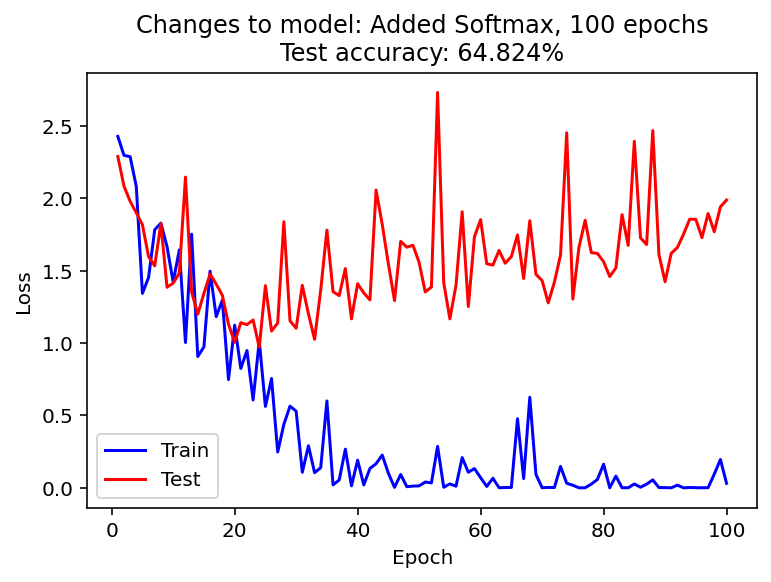

In [10]:
for i in [30,40,50,60,70,80,90,100]:
  print('#' * 30)
  print(f'Epochs: {i}')
  print('#' * 30)
  net = CNN_FINAL().cuda()
  train_loss_history, test_loss_history = train_network(net, i)
  acc = calc_accuracy(net)
  plot_loss(train_loss_history, test_loss_history, acc, f'Added Softmax, {i} epochs')